In [16]:
# load dataset
import pandas as pd
import numpy as np

df = pd.read_csv("../../datasets/processed/559-train.csv")
df[["iob", "basal", "bolus"]] = df[["iob", "basal", "bolus"]].applymap(lambda x: 0 if x < 0 else x)
df = df.dropna(axis=0)

# discretize basal and bolus
bins_for_basal_bounds = np.linspace(-0.1, 5.1, 257) # 256 - upper bound is 5
bins_for_bolus_bounds = np.linspace(-0.1, 25.1, 257) # 256 - upper bound is 25

df['basal_binned'] = pd.cut(df['basal'], bins=bins_for_basal_bounds, labels=False)
df['bolus_binned'] = pd.cut(df['bolus'], bins=bins_for_bolus_bounds, labels=False)

df.head(3)

/var/folders/p4/hpn1jhfx39bdjtyx1rrh_lrw0000gn/T/ipykernel_2063/3690429507.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[["iob", "basal", "bolus"]] = df[["iob", "basal", "bolus"]].applymap(lambda x: 0 if x < 0 else x)


,time,glu_raw,glu,glu_d,glu_t,hr,hr_d,hr_t,iob,hour,basal,bolus,done,basal_binned,bolus_binned
160,2021-12-07 13:20:00,206.0,0.557703,-0.581471,-1.257560,-0.038840,0.182794,-1.276998,2.230825,0.541667,0.0,0.0,0,4,1
161,2021-12-07 13:25:00,196.0,0.415985,-1.467792,-1.171252,-0.292948,-0.364849,0.197282,2.111984,0.541667,0.0,0.0,0,4,1
162,2021-12-07 13:30:00,181.0,0.203408,-2.206392,-1.430175,-0.292948,0.000246,0.040640,1.992197,0.541667,0.0,0.0,0,4,1


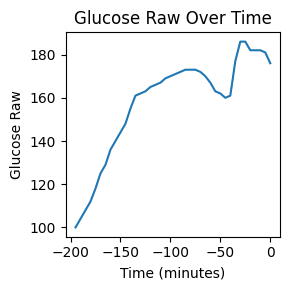

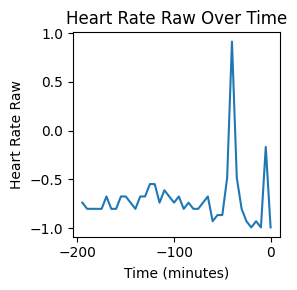

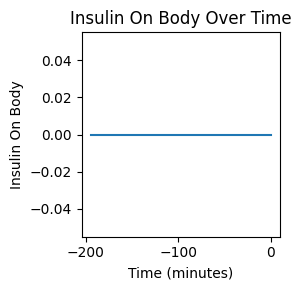

100%|██████████| 196/196 [00:27<00:00,  7.03it/s]


In [17]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def generate_imgs_for_training(data, index, indent=50, verbose=False, figsize=(3,3)):
  
    # Ensure that 'time' column is a datetime object
    data['time'] = pd.to_datetime(data['time'])
    
    # Extract the patch
    patch = data[index-indent:index].copy()

    # Calculate time since the current index
    current_time = patch.iloc[-1]['time']
    patch['time_since'] = (patch['time'] - current_time).dt.total_seconds() / 60
    
    # Plot the data with the specified figure size
    for metric, ylabel, filename in [
        ('glu_raw', 'Glucose Raw', 'glu'),  # glucose
        ('hr', 'Heart Rate Raw', 'hr'),     # heart rate
        ('iob', 'Insulin On Body', 'iob'),   # insulin on body
        #('basal', 'Basal', 'basal'),        # basal
        #('bolus', 'Bolus', 'bolus')]:       # bolus
        ]:

        plt.figure(figsize=figsize)
        plt.plot(patch['time_since'], patch[metric])
        plt.xlabel('Time (minutes)')
        plt.ylabel(ylabel)
        plt.title(f'{ylabel} Over Time')
        plt.tight_layout()
        plt.savefig(f"./img_data/{filename}_{index}.png", dpi=70)
        
        if verbose: plt.show()
        else: plt.close()

    # add urls to df
    data.at[index, "glu_url"] = f"./img_data/glu_{index}.png"
    data.at[index,"hr_url"] = f"./img_data/hr_{index}.png"
    data.at[index,"iob_url"] = f"./img_data/iob_{index}.png"
    #data.at[index,"basal_url"] = f"./img_data/basal_{index}.png"
    #data.at[index,"bolus_url"] = f"./img_data/bolus_{index}.png"

    return data


# QUESTIONS
# what text to associate?
# what data to include?
# interval length? randomize?
# fixed ylim?
# discrete tokenization

df = generate_imgs_for_training(df, 5000, 40, verbose=True)

# Generate dataset
interval = 50
for i in tqdm(range(interval, len(df), interval)):
    df = generate_imgs_for_training(df, i, interval)

In [20]:
# format for Llama Factory
import json

def format_as_chat(img_paths, text, output=""):

  return {
    "messages": [
      {
        "content": f"{text}<image><image><image>",
        "role": "user"
      },
      {
        "content": output,
        "role": "assistant"
      }
    ],
    "images": [
      img_paths,
    ]
  }

# Text description
text = "You predict basal and bolus"

# Create json format for Llama factory
data_json = [
    format_as_chat(
      [row["glu_url"],row["hr_url"],row["iob_url"]],
      text = text,
      output = f"{int(row['basal_binned'])} {int(row['bolus_binned'])}",
    ) for i, row in df.dropna().iterrows()]


# Store JSON data in a file
with open("data.json", 'w') as file:
    json.dump(data_json, file, indent=4)